# IF evaluation from InfoBench

InFoBench: Evaluating Instruction Following Ability in Large Language Models


The InFoBench is a dataset for IF tasks, and it contains lots of decomposed questions for each inference and then we can use a SOTA model for the final evaluations.

In this study, this IF tasks are implemented by the following steps:

1. Collect all questions from the dataset and then the decomposed Instructions detailed questions are listed

| prompt_question                                                                                                                          | Answer | Evaluation_prompt | Evaluation_results |
|--------------------------------------------------------------------------------------------------------------------------------------------|--------|------------------|--------------------|
|You are a conscientious assistant, and you must answer my questions exactly as my questions require. <</SYS>> Given a programming language and the name of a function, write a command to show how to use the function. Language: Python Function: input |Of course! Here is a command to show how to use the `input` function in Python: name = input("What is your name? ") Print the user's input print("Hello,", name, "!") This code will prompt the user to enter their name, and then it will print a message with the user's name in it. I hope this helps! Let me know if you have any other questions.    | ['Does the generated text include a command?''Is the command in the generated text in the given programming language (Python)?''Does the command in the generated text show how to use the function in the given input?''Is the command in the generated text correct?'] |[True, True, True, True]             |


2. Then get the response from models and calculate the accuracy score evaluated by ChatGPT models.
3. Finally, do the statistical analysis and causal modeling for future usage.


In [ ]:
import pandas as pd
import time
from openai import OpenAI
from tqdm import tqdm
import os

# Read data using
SYS_MSG = "Based on the provided Input (if any) and Generated Text, answer the ensuing Questions with either a YES or NO choice. Your selection should be based on your judgment as well as the following rules:\n\n- YES: Select 'YES' if the generated text entirely fulfills the condition specified in the question. However, note that even minor inaccuracies exclude the text from receiving a 'YES' rating. As an illustration. consider a question that asks. \"Does each sentence in the generated text use a second person?” If even one sentence does not use the second person, the answer should NOT be 'YES'. To qualify for a 'YES' rating, the generated text must be entirely accurate and relevant to the question\n\n- NO: Opt for 'NO' if the generated text fails to meet the question's requirements or provides no information that could be utilized to answer the question. For instance, if the question asks. \"Is the second sentence in the generated text a compound sentence?\" and the generated text only has one sentence. it offers no relevant information to answer the question. Consequently, the answer should be 'NO'.'''"

foler_path = "Paper Experiment Results/New_filtered/IF"
file_name = "supplementary_IF.csv"
output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
temperature = 0

In [ ]:
def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


_data["pure_response"] = _data.apply(extract_pure_response, axis=1)

In [ ]:
import os

if os.path.exists(output_path):
    data_evaluated = pd.read_csv(output_path)
    last_idx = data_evaluated.shape[0]
else:
    last_idx = 0

In [ ]:
test_times = 0
times = 0
pbar = tqdm(total=len(_data))
for index, entry in tqdm(_data.iterrows()):
    if index <= last_idx:
        pbar.update(1)
        continue
    updated_row = entry.copy()
    input_task = entry["input"]
    output = entry["pure_response"]
    if output is None:  # skip if result hasn't been generated
        continue
    message = []
    answer = ""
    for question in process_string(entry["decomposed_questions"]):
        if len(message) == 0:
            if input_task:
                content = f'{SYS_MSG}\n\nInput:\n"{input_task}"\n\nGenerated Text:\n"{output}"\n\nQuestion:\n{question}\n'
            else:
                content = f'{SYS_MSG}\n\nGenerated Text:\n"{output}"\n\nQuestion:\n{question}\n'
        else:
            content = f"{question}\n"
        # print(content)
        message.append({"role": "user", "content": content})
        # create a chat completion
        success = False
        early_stop = False
        rep = 0
        while not success:
            if rep > 2:
                break
            try:
                completion = client.chat.completions.create(
                    model=eval_model,
                    messages=message,
                    temperature=temperature,
                )
                generation = completion.choices[0].message.content
                message.append({"role": "assistant", "content": generation})
                rep += 1
                # check if generation is yes or no
                if generation.lower().startswith(
                    "yes"
                ) or generation.lower().startswith("no"):
                    if generation.lower().startswith("yes"):
                        answer += "Yes\n"
                    else:
                        answer += "No\n"
                else:
                    if "YES" in generation and "NO" not in generation:
                        answer += "Yes\n"
                    elif "YES" not in generation and "NO" in generation:
                        answer += "No\n"
                    else:
                        for msg in message:
                            print(msg["content"])
                        print("NO YES or NO answer!" + generation)
                        answer += "None\n"
                        early_stop = True
                        break
                success = True
            except Exception as e:
                rep += 1
                print("ERROR!")
                print(e)
                print("Retry!")
                time.sleep(3)

        # when no answer occurs, break the loop and continue to next instance
        if early_stop:
            break

    answer = answer[:-1]
    # save eval results as List[bool]
    bool_results = []
    for i in answer.split("\n"):
        if i == "Yes":
            bool_results.append(True)
        elif i == "No":
            bool_results.append(False)
        else:
            bool_results.append(None)

    updated_row["eval"] = bool_results
    updated_row["messages_openai"] = message
    test_times += 1
    updated_dataframe = pd.DataFrame([updated_row])
    pbar.update(1)
    if not os.path.exists(output_path):
        updated_dataframe.to_csv(output_path, index=False, mode="w", header=True)
    else:
        updated_dataframe.to_csv(output_path, index=False, mode="a", header=False)
    times = times + 1

# Test On one single result

In [ ]:
import pandas as pd

df = pd.read_csv(
    "/home/lujun/local/temperature_eval/Paper Experiment Results/New_filtered/IF/exp_result_Meta-Llama-3-8B-Instruct_20240503202231_evaluated.csv"
)

In [ ]:
df = df[~df["eval"].str.contains("None", na=False)]


def count_true_false(string):
    string_lower = string.lower()
    count_true = string_lower.count("true")
    count_false = string_lower.count("false")
    return count_true, count_false


df[["true_count", "false_count"]] = df["eval"].apply(count_true_false).apply(pd.Series)
df["DRFR"] = df["true_count"] / (df["true_count"] + df["false_count"])

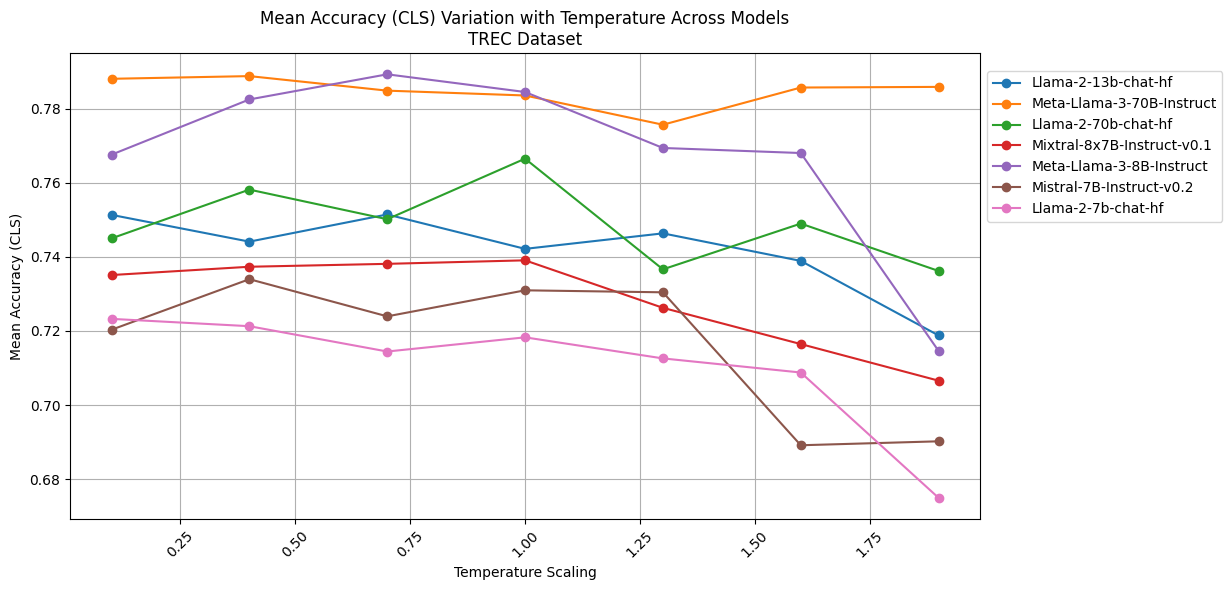

In [ ]:
import matplotlib.pyplot as plt

grouped_data = df.groupby(["model", "Temperature"])["DRFR"].mean()

models = df["model"].unique()

plt.figure(figsize=(10, 6))
for model in models:
    model_data = grouped_data[model]
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker="o",
        label=model,
    )

plt.xlabel("Temperature Scaling")
plt.ylabel("Mean Accuracy (CLS)")
plt.title("Mean Accuracy (CLS) Variation with Temperature Across Models\nTREC Dataset")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="center left", bbox_to_anchor=(1, 0.8))

plt.show()

# Test On all Models

In [2]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
output_photo_name = f"IF_{current_time_str}.svg"
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}

marker_map = {
    "Llama-2-7b-chat-hf": ".",
    "Llama-2-13b-chat-hf": "*",
    "Llama-2-70b-chat-hf": "o",
    "Meta-Llama-3-8B-Instruct": "+",
    "Meta-Llama-3-70B-Instruct": "^",
    "Mistral-7B-Instruct-v0.2": "<",
    "Mixtral-8x7B-Instruct-v0.1": ">",
}

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
}

folder_path = "data/IF"
output_photo_name = f"IF_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["model_encoded"] = df["model_name"].map(model_map)
df["Temperature"] = df["Temperature"].astype(float).round(1)
df = df[~df["eval"].str.contains("None", na=False)]


def count_true_false(string):
    string_lower = string.lower()
    count_true = string_lower.count("true")
    count_false = string_lower.count("false")
    return count_true, count_false


df[["true_count", "false_count"]] = df["eval"].apply(count_true_false).apply(pd.Series)
df["DRFR"] = df["true_count"] / (df["true_count"] + df["false_count"])

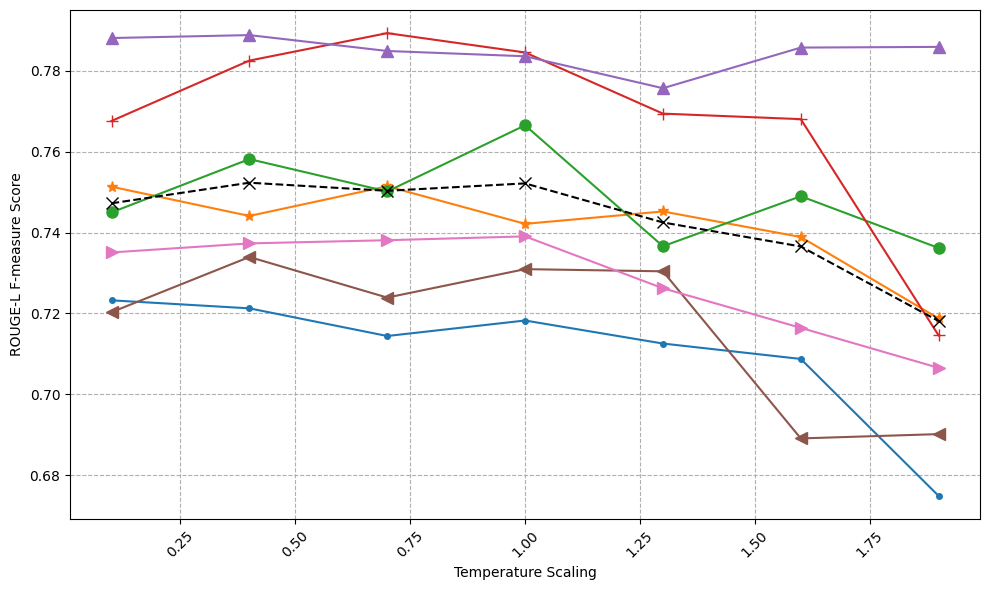

In [3]:
grouped_data = df.groupby(["model", "Temperature"])["DRFR"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["DRFR"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("ROUGE-L F-measure Score")
# plt.title("Summarization\n Mean ROUGE-L F-measure with Temperature Across Models")
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [4]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import pandas as pd


metric_name = "DRFR"

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
# Calculate the results for all the models
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    # Normalised Accuracy Value So That The Accuracy Can Be comparable
    accuracy = model_data[metric_name].values
    accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
    # Calculate Correlation Metrics
    corr, p_value = spearmanr(temperatures, accuracy)
    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()
    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj
    beta_hat = model.params
    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


# The Calcluation for all the results accross the model
model_data = df
temperatures = model_data["Temperature"].values
accuracy = model_data[metric_name].values
accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
corr, p_value = spearmanr(temperatures, accuracy)
temperatures = sm.add_constant(temperatures)
model = sm.OLS(accuracy, temperatures).fit()
predictions = model.predict(temperatures)
se = np.sqrt(mean_squared_error(accuracy, predictions))
r_squared = model.rsquared
r_squared_adj = model.rsquared_adj
beta_hat = model.params
results.append(
    {
        "model": "All",
        "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
        "r_squared": f"{r_squared:.3f}",
        "r_squared_adj": f"{r_squared_adj:.3f}",
        "Spearman correlation Coefficient": f"{corr:.3f}",
        "P_value": f"{p_value:.3f}",
        "se": f"{se:.3f}",
        "beta_hat_0": f"{beta_hat[0]:.3f}",
        "beta_hat_1": f"{beta_hat[1]:.3f}",
    }
)


grouped_data = df.groupby(["Temperature"])[metric_name].mean().reset_index()

average_performance = grouped_data[metric_name].mean()

standard_deviation = grouped_data[metric_name].std()

range_value = grouped_data[metric_name].max() - grouped_data[metric_name].min()
statistical_range_percentage = (range_value / average_performance) * 100

coefficient_of_variation = (standard_deviation / average_performance) * 100

average_performance, standard_deviation, statistical_range_percentage, coefficient_of_variation

results_df = pd.DataFrame(results)
results_df

filtered_row = results_df[results_df["model"] == "All"]
spearman_coefficient = float(filtered_row["Spearman correlation Coefficient"].values[0])
p_value = float(filtered_row["P_value"].values[0])

print(f"Average Performance: {average_performance:.3f}")
print(f"Spearman correlation Coefficient: {spearman_coefficient:.3f}")
print(f"p_value: {p_value:.3f}")
# print(f"Standard Deviation: {standard_deviation:.3f}")
print(f"Range Percentage: {statistical_range_percentage:.3f}%")
print(f"Coefficient of Variation: {coefficient_of_variation:.3f}")

(0.7427309343937638,
 0.012252139805498654,
 4.6001663905486945,
 1.6496067738849693)

Average Performance: 0.743
Spearman correlation Coefficient: -0.033
p_value: 0.000
Range Percentage: 4.600%
Coefficient of Variation: 1.650


In [24]:
data_16 = df[
    (df["model_name"] == "Meta-Llama-3-8B-Instruct") & (df["Temperature"] == 1.6)
][
    [
        "instruction",
        "decomposed_questions",
        "llama2_chat_initial_prompt",
        "Temperature",
        "pure_response",
        "DRFR",
        "messages_openai",
    ]
]

data_19 = df[
    (df["model_name"] == "Meta-Llama-3-8B-Instruct") & (df["Temperature"] == 1.9)
][
    [
        "instruction",
        "decomposed_questions",
        "llama2_chat_initial_prompt",
        "Temperature",
        "pure_response",
        "DRFR",
        "messages_openai",
    ]
]

In [25]:
merged_data = pd.merge(data_16, data_19, on="instruction", suffixes=("_16", "_19"))
merged_data[merged_data["DRFR_16"] - merged_data["DRFR_19"] > 0].count()

,instruction,decomposed_questions_16,llama2_chat_initial_prompt_16,Temperature_16,pure_response_16,DRFR_16,messages_openai_16,decomposed_questions_19,llama2_chat_initial_prompt_19,Temperature_19,pure_response_19,DRFR_19,messages_openai_19
0,Choose an appealing title for your post.,['Is the generated text a post title?'\n 'Is t...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,"""A Shocking Truth About Avocados: Are They as ...",0.666667,"[{'role': 'user', 'content': 'Based on the pro...",['Is the generated text a post title?'\n 'Is t...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,"A Nutritional Delight, But Modesty Advisable: ...",0.666667,"[{'role': 'user', 'content': 'Based on the pro..."
1,Given a programming language and the name of a...,['Does the generated text include a command?'\...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,Here is the command to show how to use the `in...,1.000000,"[{'role': 'user', 'content': 'Based on the pro...",['Does the generated text include a command?'\...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,Here's an example of how to use the `input` fu...,1.000000,"[{'role': 'user', 'content': 'Based on the pro..."
2,Change the first person to the third person in...,['Is the generated text expressed in third per...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,The team managed to secure a deal with a prima...,0.666667,"[{'role': 'user', 'content': 'Based on the pro...",['Is the generated text expressed in third per...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,The company was successful in augmenting its i...,0.666667,"[{'role': 'user', 'content': 'Based on the pro..."
3,Design a syllabus for the given course. Studen...,['Is the generated text a course syllabus?'\n ...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,Course Title: Programming for Everybody (Getti...,0.833333,"[{'role': 'user', 'content': 'Based on the pro...",['Is the generated text a course syllabus?'\n ...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,Syllabus for Programming for Everybody (Gettin...,0.833333,"[{'role': 'user', 'content': 'Based on the pro..."
4,Think of topics that are most common in classi...,['Does the generated text include some topics?...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,Here are some common topics that are frequentl...,1.000000,"[{'role': 'user', 'content': 'Based on the pro...",['Does the generated text include some topics?...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,Based on typical classic interview questions f...,1.000000,"[{'role': 'user', 'content': 'Based on the pro..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,Create a high-school level physics equation th...,['Does the generated text form a physics equat...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,I can create a simple physics equation for you...,1.000000,"[{'role': 'user', 'content': 'Based on the pro...",['Does the generated text form a physics equat...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,Here is a high-school level physics equation t...,0.625000,"[{'role': 'user', 'content': 'Based on the pro..."
495,Generate a non-disclosure agreement of two pag...,['Is the generated text a non-disclosure agree...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,**Page 1: Definitions and Confidential Informa...,0.545455,"[{'role': 'user', 'content': 'Based on the pro...",['Is the generated text a non-disclosure agree...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,**Page 1: Definitions and General Obligations*...,0.727273,"[{'role': 'user', 'content': 'Based on the pro..."
496,Create a hypothetical 7-day fitness and diet p...,['Does the generated text present a hypothetic...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,Here is a 7-day fitness and diet plan for impr...,0.333333,"[{'role': 'user', 'content': 'Based on the pro...",['Does the generated text present a hypothetic...,\n<s>[INST] 

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
}
model_order = list(color_map.keys())
df["Temperature"] = df["Temperature"].round(1)

# Create a single plot
fig, ax = plt.subplots(figsize=(20, 10))

# Boxplot
sns.boxplot(
    x="Temperature",
    y="DRFR",
    hue="model",
    data=df,
    palette=color_map,
    hue_order=model_order,
    ax=ax,
)

# ax.set_title("Boxplot Temperature vs spbleu")
ax.set_xlabel("Temperature Scaling")
ax.set_ylabel("spbleu")
# ax.legend(loc="upper left")

# Adjust layout
plt.tight_layout()
plt.savefig("MT_boxplot.svg", format="svg", bbox_inches="tight")
# Show the plot
plt.show()

,instruction,decomposed_questions_16,llama2_chat_initial_prompt_16,Temperature_16,pure_response_16,DRFR_16,messages_openai_16,decomposed_questions_19,llama2_chat_initial_prompt_19,Temperature_19,pure_response_19,DRFR_19,messages_openai_19
0,Choose an appealing title for your post.,['Is the generated text a post title?'\n 'Is t...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,"""A Shocking Truth About Avocados: Are They as ...",0.666667,"[{'role': 'user', 'content': 'Based on the pro...",['Is the generated text a post title?'\n 'Is t...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,"A Nutritional Delight, But Modesty Advisable: ...",0.666667,"[{'role': 'user', 'content': 'Based on the pro..."
1,Given a programming language and the name of a...,['Does the generated text include a command?'\...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,Here is the command to show how to use the `in...,1.000000,"[{'role': 'user', 'content': 'Based on the pro...",['Does the generated text include a command?'\...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,Here's an example of how to use the `input` fu...,1.000000,"[{'role': 'user', 'content': 'Based on the pro..."
2,Change the first person to the third person in...,['Is the generated text expressed in third per...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,The team managed to secure a deal with a prima...,0.666667,"[{'role': 'user', 'content': 'Based on the pro...",['Is the generated text expressed in third per...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,The company was successful in augmenting its i...,0.666667,"[{'role': 'user', 'content': 'Based on the pro..."
3,Design a syllabus for the given course. Studen...,['Is the generated text a course syllabus?'\n ...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,Course Title: Programming for Everybody (Getti...,0.833333,"[{'role': 'user', 'content': 'Based on the pro...",['Is the generated text a course syllabus?'\n ...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,Syllabus for Programming for Everybody (Gettin...,0.833333,"[{'role': 'user', 'content': 'Based on the pro..."
4,Think of topics that are most common in classi...,['Does the generated text include some topics?...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,Here are some common topics that are frequentl...,1.000000,"[{'role': 'user', 'content': 'Based on the pro...",['Does the generated text include some topics?...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,Based on typical classic interview questions f...,1.000000,"[{'role': 'user', 'content': 'Based on the pro..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,Create a high-school level physics equation th...,['Does the generated text form a physics equat...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,I can create a simple physics equation for you...,1.000000,"[{'role': 'user', 'content': 'Based on the pro...",['Does the generated text form a physics equat...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,Here is a high-school level physics equation t...,0.625000,"[{'role': 'user', 'content': 'Based on the pro..."
495,Generate a non-disclosure agreement of two pag...,['Is the generated text a non-disclosure agree...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,**Page 1: Definitions and Confidential Informa...,0.545455,"[{'role': 'user', 'content': 'Based on the pro...",['Is the generated text a non-disclosure agree...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.9,**Page 1: Definitions and General Obligations*...,0.727273,"[{'role': 'user', 'content': 'Based on the pro..."
496,Create a hypothetical 7-day fitness and diet p...,['Does the generated text present a hypothetic...,\n<s>[INST] <<SYS>>\nYou are a conscientious a...,1.6,Here is a 7-day fitness and diet plan for impr...,0.333333,"[{'role': 'user', 'content': 'Based on the pro...",['Does the generated text present a hypothetic...,\n<s>[INST] 

In [4]:
from scipy.stats import kendalltau

correlations = {}
p_values = {}
for model in models:
    # Extract data for the current model
    model_data = grouped_data[model]
    temperatures = model_data.index.get_level_values("Temperature")
    mean_labels = model_data.values

    # Compute Kendall correlation
    corr, p_value = kendalltau(temperatures, mean_labels)

    # Store results
    correlations[model] = corr
    p_values[model] = p_value

# Print or use the results as needed
for model in models:
    print(f"Model: {model}")
    print(f"Kendall correlation coefficient: {correlations[model]}")
    print(f"P-value: {p_values[model]}")
    print()

Model: Llama-2-7b-chat-hf
Kendall correlation coefficient: -0.9047619047619049
P-value: 0.002777777777777778

Model: Llama-2-13b-chat-hf
Kendall correlation coefficient: -0.6190476190476191
P-value: 0.06904761904761905

Model: Llama-2-70b-chat-hf
Kendall correlation coefficient: -0.33333333333333337
P-value: 0.3813492063492063

Model: Meta-Llama-3-8B-Instruct
Kendall correlation coefficient: -0.33333333333333337
P-value: 0.3813492063492063

Model: Meta-Llama-3-70B-Instruct
Kendall correlation coefficient: -0.23809523809523814
P-value: 0.5619047619047619

Model: Mistral-7B-Instruct-v0.2
Kendall correlation coefficient: -0.33333333333333337
P-value: 0.3813492063492063

Model: Mixtral-8x7B-Instruct-v0.1
Kendall correlation coefficient: -0.4285714285714286
P-value: 0.2388888888888889

